In [2]:
import kaggle as kg
import os
import pandas as pd
import numpy as np
import matplotlib as mp

os.environ['KAGGLE_USERNAME'] ='taylorjmurray' #os.environ is a mapping object, think dictionary. os.environ is created as soon as os module is imported.
os.environ['KAGGLE_KEY'] = '9514abe911ad574d3d1f13f9dfac480e'
kg.api.authenticate()
download_path = "/Users/tayma/datasets"

kg.api.dataset_download_files(dataset= 'austinreese/usa-housing-listings', path = download_path, unzip = True)
file_path = os.path.join(download_path, 'housing.csv') #joins the download_path and 'housing.csv' and returns it as a new path




Dataset URL: https://www.kaggle.com/datasets/austinreese/usa-housing-listings


In [3]:

db = pd.read_csv(file_path)
db.info() #To get a sense of the contents of the data- in particular its features.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384977 entries, 0 to 384976
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       384977 non-null  int64  
 1   url                      384977 non-null  object 
 2   region                   384977 non-null  object 
 3   region_url               384977 non-null  object 
 4   price                    384977 non-null  int64  
 5   type                     384977 non-null  object 
 6   sqfeet                   384977 non-null  int64  
 7   beds                     384977 non-null  int64  
 8   baths                    384977 non-null  float64
 9   cats_allowed             384977 non-null  int64  
 10  dogs_allowed             384977 non-null  int64  
 11  smoking_allowed          384977 non-null  int64  
 12  wheelchair_access        384977 non-null  int64  
 13  electric_vehicle_charge  384977 non-null  int64  
 14  come

An important detail to keep in mind about the price feature:

* Price is price per month and is in US dollars. This explains the low values found below.


In [4]:
db.describe()

,id,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
count,3.849770e+05,3.849770e+05,3.849770e+05,384977.000000,384977.000000,384977.000000,384977.000000,384977.000000,384977.000000,384977.000000,384977.000000,383059.000000,383059.000000
mean,7.040982e+09,8.825722e+03,1.059900e+03,1.905345,1.480718,0.726890,0.707918,0.731771,0.082111,0.012871,0.048128,37.233487,-92.700631
std,8.800376e+06,4.462200e+06,1.915076e+04,3.494572,0.618061,0.445557,0.454721,0.443038,0.274535,0.112718,0.214036,5.546171,16.531980
min,7.003808e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-43.533300,-163.894000
25%,7.035979e+09,8.050000e+02,7.500000e+02,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.454700,-100.775000
50%,7.043320e+09,1.036000e+03,9.490000e+02,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.647800,-87.745100
75%,7.048426e+09,1.395000e+03,1.150000e+03,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,41.138300,-81.179600
max,7.051292e+09,2.768307e+09,8.388607e+06,1100.000000,75.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,102.036000,172.633000


We observe that there are houses with 0 price and sqfeet. We will get rid of these. Also, the maximum price is quite high, we should check if this is an extreme outlier or bad data.

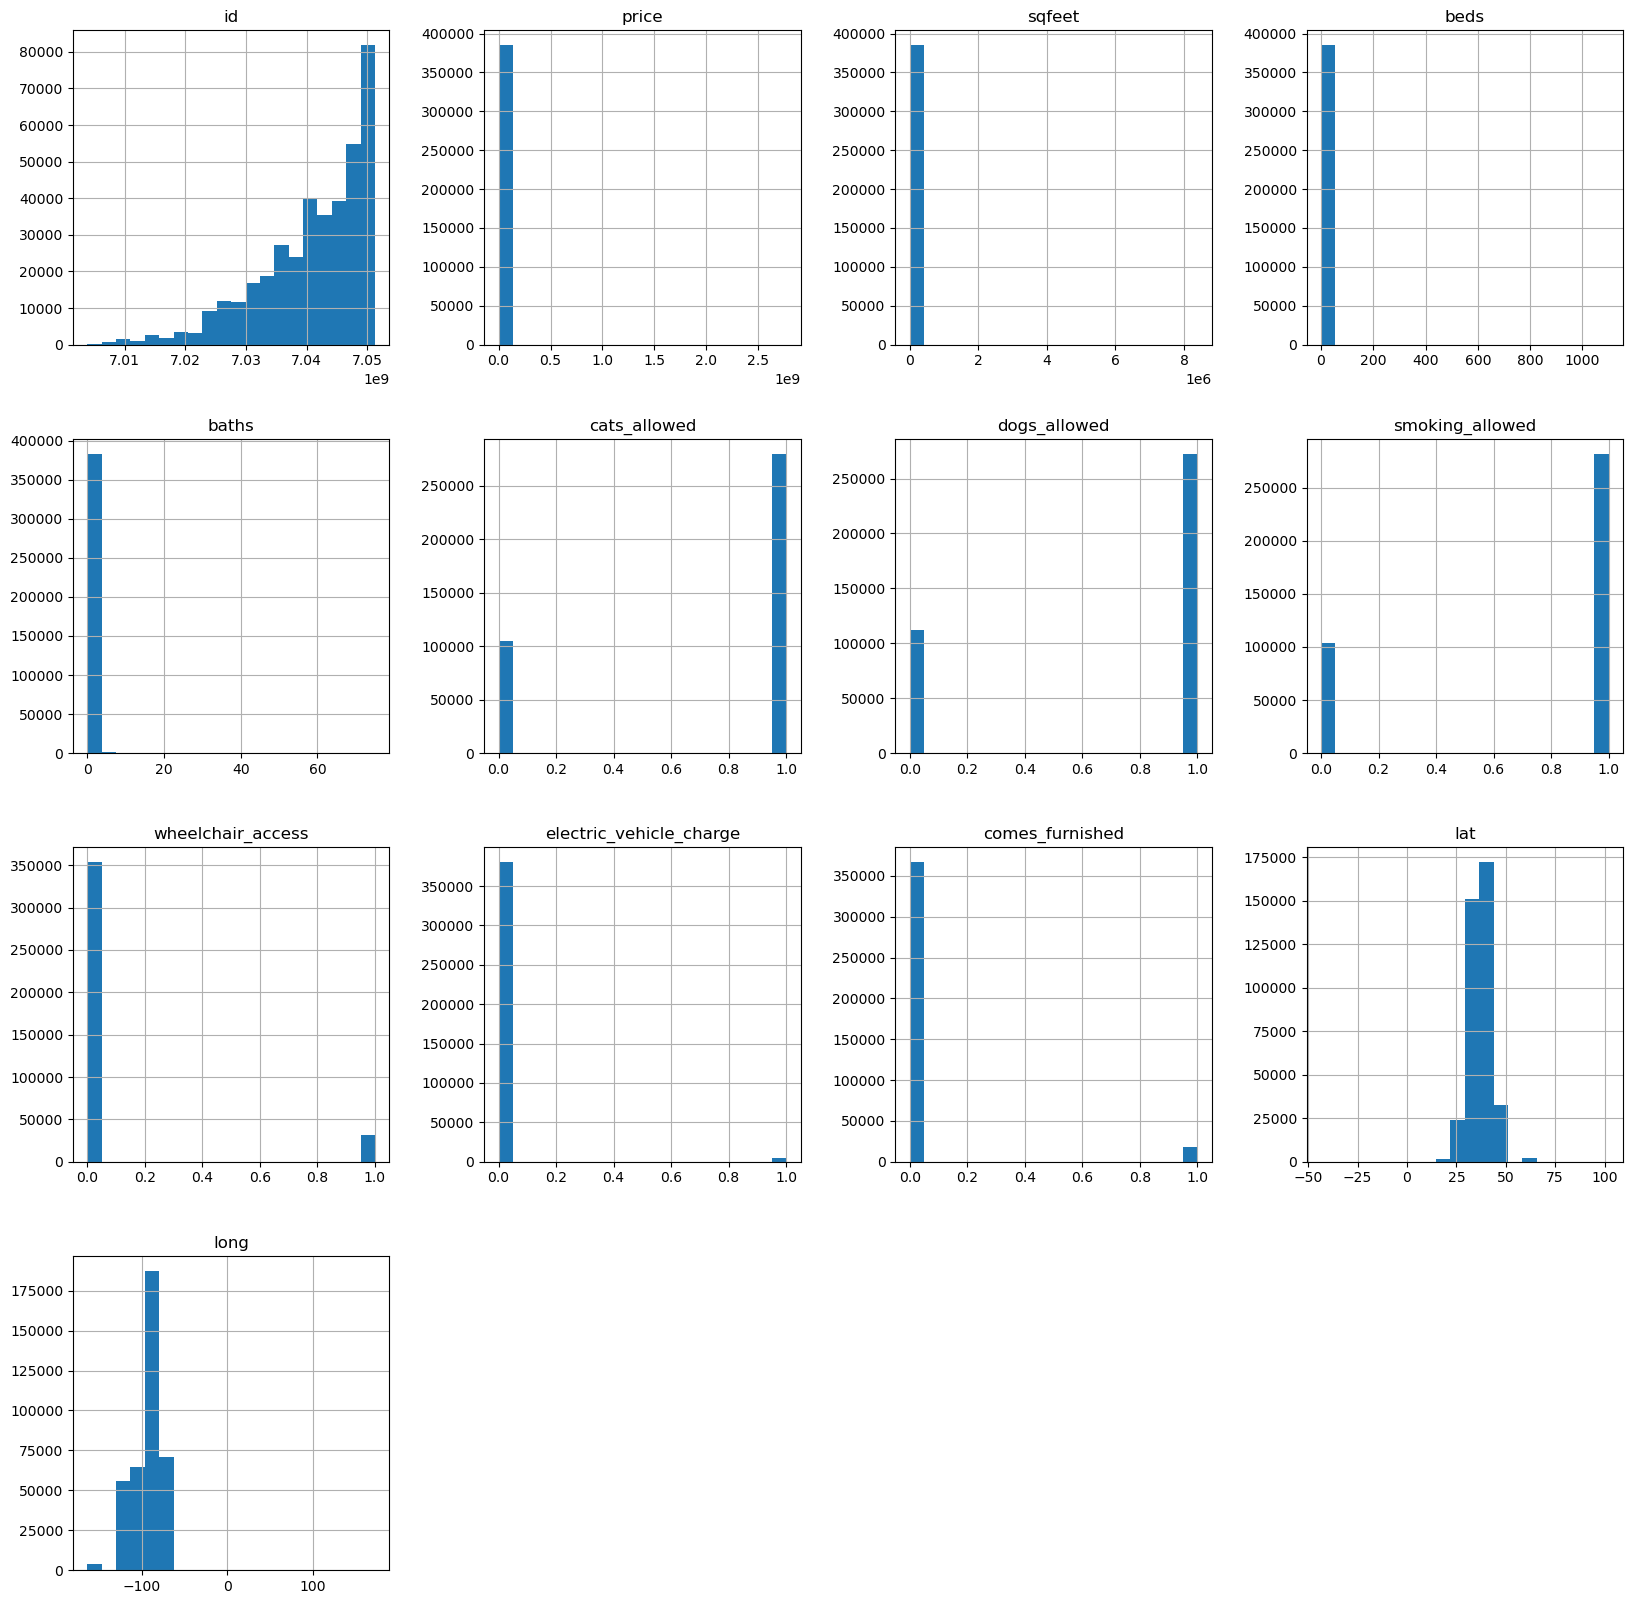

In [5]:
data =db.copy()

%matplotlib inline
data.hist(bins=20, figsize=(20,20))
mp.pyplot.show() # Creates a histogram for each feature




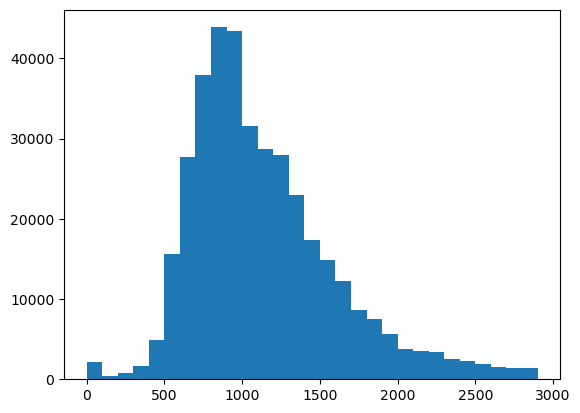

In [6]:
# The histograms for the 'price' and 'sqfeet' features are odd because the x axis is in scientific notation
# We fix this by specifying the bins for our histogram.
# One can also use normalization
import matplotlib.pyplot as plt

price_data = data['price']

price_bins = [i*100 for i in range(30)]
plt.hist(price_data, bins = price_bins)
plt.show()

In [7]:
# Create a test set
# Want this test set to remain across updates to the given data set to do this we use a hash function


import hashlib 

def hash_to_value(value):
    return int(hashlib.md5(str(value).encode()).hexdigest(),16)%(10**8)/10**8

# We describe hash_to_value
# str(value).encode() transforms the string to a UTF-8 byte string which is required for hashing
# hashlib.md5(...).hexdigest() converts the UTF-8 byte string to a hexstring
# int(..., 16) coverts the hex string to a base 10 integer
# % 10**8 turns int(...,16) into a 8 digit integer
# / 10**8 gives us a number in [0,1) which is ideal for fair splitting and becaus
# the key point is that the result is a determinisitic float, meaning it will not change output for any run.
# More over MD5 distributes inputs uniformly and randomly over its output range. This allows us to use test_size = 0.2
# in the function split below with certainty that the test set will have size roughly 20% of the original.

def split(df, id_column, test_size = 0.2):
    df = df.copy() # Avoids modifying the dataframe
    df['hash_value'] =  df[id_column].apply(hash_to_value) # Creates a new column called 'hash_value' that applies hash_to_value to every element in the id_column
    test_mask = df['hash_value'] < test_size # Creates a mask (i.e a boolean array) picking out the instances whose hash_value is less than test_size
    test_set = df[test_mask] # returns a subset of the dataset whose instances have hash_value < test_size
    train_set = df[~test_mask] # returns a subset of the dataset whose instances have hash_value >= test_size
    return test_set, train_set

test_set, train_set = split(data, 'id', test_size = 0.2)




In [8]:

correlation_matrix = train_set.corr(numeric_only = True)
correlation_matrix['price']


id                        -0.001130
price                      1.000000
sqfeet                     0.000008
beds                       0.000061
baths                      0.000174
cats_allowed               0.001098
dogs_allowed               0.001115
smoking_allowed            0.001094
wheelchair_access         -0.000450
electric_vehicle_charge   -0.000199
comes_furnished           -0.000416
lat                       -0.001559
long                       0.000855
hash_value                 0.000718
Name: price, dtype: float64

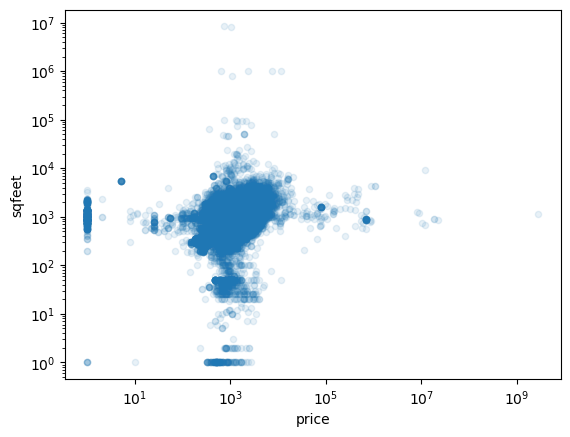

In [9]:


train_set.plot(kind = "scatter", x ="price", y ="sqfeet", logx = True, logy = True, alpha = 0.1)
mp.pyplot.show()


In [10]:
# Cleanup Data
#1.) Delete labels and put labels aside.
#2.) Select columns we will use in linear regression
#3.) Replace na/missing data with median
#4.) Normalize selected columns.


# Delete labels

def drop_column(db, column):
    data = db.copy()
    return data.drop(column, axis = 1)

def label_data(db, column):
    data = db.copy()
    return data[column]

# Select columns we will use in linear regression

def linear_regression_variables(db : pd.DataFrame, columns : list[str]):
    if columns is None or columns == []:
        raise ValueError("No Columns to select")
    
    invalid_columns = [col for col in columns if col not in db.columns]
    if invalid_columns: #python treats empty containers as False or True otherwise
        raise ValueError("One or more inputed columns are not columns in the inputed DataFrame")

    return db[columns].copy()



# Replace na/missing data with a method

from typing import Callable

def replace(db : pd.DataFrame, column_to_method : dict):
    if column_to_method is None :
        raise ValueError("No Columns or Methods specified")
    
    data = db.copy()
    
    for col in column_to_method.keys():
        replacement = column_to_method[col](data[col])
        data[col] = data[col].fillna(replacement)
    return data

# Normalizing function

def normalize_columns(db: pd.DataFrame, columns : list[str]):
    
    if columns is None or columns == []:
        raise ValueError("No columns to normalize")
    
    data = db.copy()
    
    for col in columns:
        col_max = data[col].max()
        col_min = data[col].min()
        if col_min == col_max:
            # want to avoid division by zero
            data[col].nan
        else:
            data[col] = (data[col] - col_min)/(col_max - col_min)
    return data

            





Predictions: [11386.51234102 11409.27296479  9977.1616138   9998.30039424
  9977.17992248  9977.08990483  9977.1616138  11408.31175943
 11408.12409552  9977.17992248 12820.24400962  9977.25010573
  9977.24705428 11408.1561357  11408.10731257 11408.52536062
 11387.30876832 11408.06306661 11408.91747138  9977.07922477
 11386.92276045  9976.96937273 12818.73812122  9955.342361
 11408.90221415 11386.78391968  9955.46441882 10681.82629735
  9955.53155063  9955.39728702  9998.75811108  9977.1616138
  9955.75125471  9977.28672307  9977.38742078 11408.29192503
  9976.69169118  9977.07312188 11430.3430877   9976.99683574
  9977.07312188  9977.07312188  9955.75125471  9955.78482061
 11387.41862036  9955.57121942 11408.33159382 11387.07075556
  9977.40725517 11386.46656933  9955.31642371  9955.43848154
  9977.07922477  9955.54070496 12114.06428333  9976.72220564
 13566.87348087 11366.07539307  9977.29587741  9998.58265296
  9977.07312188  9998.30039424  9976.69169118  9976.69169118
  9976.6916911

In [ ]:
# split up by state
# first we define a function automating the last cell
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def linear_regression_mse(training_data, features_to_use, columns_to_normalize, label_column):
    
    training_data_no_labels = drop_column(training_data, label_column)
    label_data = training_data[label_column]
    label_data = label_data.fillna(label_data.median())

    for col in features_to_use:
        median = training_data_no_labels[col].median()
        training_data_no_labels[col]= training_data_no_labels[col].fillna(median)

    new_training_data = linear_regression_variables(training_data_no_labels, features_to_use)
    normalized_data = normalize_columns(new_training_data, columns_to_normalize)
    
    lin_reg = LinearRegression()
    lin_reg.fit(normalized_data, label_data)

    predics = lin_reg.predict(normalized_data)
    lin_mse = mean_squared_error(label_data, predics)
    return lin_mse


linear_regression_mse(train_set, features_to_use = ['sqfeet', 'beds','baths'], columns_to_normalize = ['sqfeet'], label_column = ['price'])
    

24890628866718.438

In [28]:
for state in train_set['state'].unique():
    state_train_set = pd.DataFrame() # makes sure old state_train_set is erased in new interation
    state_train_set = train_set[train_set['state'] == state]
    mse = linear_regression_mse(state_train_set, features_to_use = ['sqfeet', 'beds','baths'], columns_to_normalize = ['sqfeet'], label_column = ['price'])
    print(f"The linear regression mse for {state} is {mse}")


The linear regression mse for ca is 21900856358.082817
The linear regression mse for co is 25727726.03640288
The linear regression mse for ct is 2012142.4653350685
The linear regression mse for dc is 442312.8090046216
The linear regression mse for fl is 5636255976.283572
The linear regression mse for de is 106780.33760918127
The linear regression mse for ga is 691011010602494.2
The linear regression mse for hi is 651571.2021681399
The linear regression mse for id is 122105.0564856489
The linear regression mse for il is 726218.0814045769
The linear regression mse for in is 182238413.78078482
The linear regression mse for ia is 103042226.50664748
The linear regression mse for ks is 51532.08522141843
The linear regression mse for ky is 50488.22266056223
The linear regression mse for la is 155531710.49714267
The linear regression mse for me is 220438.77616111565
The linear regression mse for mi is 6470129298.67529
The linear regression mse for md is 137468.4868143405
The linear regression 